In [129]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

sys.path.insert(0, os.path.join(".."))
%reload_ext autoreload
%autoreload 2

In [130]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

## General Bilinear Quadratic

In [142]:
import scipy.linalg as sla

nx=2
ny=10

problem_n = pr.BilinearQuadraticSaddle.with_parameters(nx=nx, ny=ny, L_x=10, mu_x=1, L_y=10, mu_y=1, L_xy=13.99959999, mu_xy=2)
L = max(problem_n.L_x, problem_n.L_y, problem_n.L_xy)
print(sla.svdvals(problem_n.C))
params = {"apdg": None,
          "lpd": None,
          'altgd': {"lr": 1 / (2*L)},
          'simgd': {"lr": 1 / (2*L)},
          # 'avg': {"lr": 1 / (2*L)},
          'eg': {"lr": 1 / (2*L)},
          'omd': {"lr": 1 / (2*L)},
          # 'AA': {"lr": 1 / (2*L), 
          #        "k": 10,
          #        "type2": True,
          #        "reg": 1e-10,
          #        "gamma": 1e-26
          #       }
         }
 # {'adam':0.01, 'fr':0.05}

x0 = np.random.randn(nx, )
y0 = np.random.randn(ny, )
type2=True
iteration = 1000
methods_dict = ut.main(problem_n, iteration, x0.copy(), y0.copy(), params)

[10.          8.53822769  7.19189845  5.96101229  4.84556921  3.84556921
  2.96101229  2.19189845  1.53822769  1.        ]


LPD:  61%|███████████████████████████████████████████▋                            | 607/1000 [00:00<00:00, 4753.76it/s]


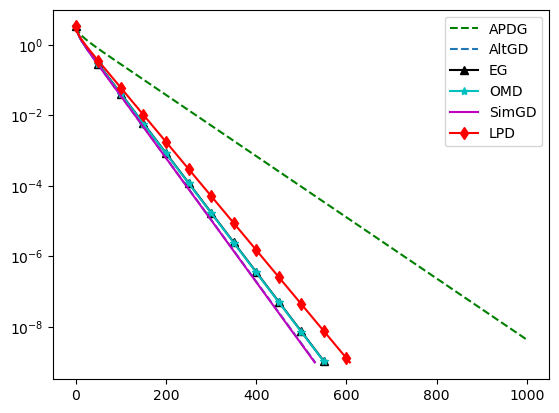

In [143]:
%matplotlib inline
plot_interval = 1
markevery=50
for method in methods_dict:
    if method not in []:
        plt.semilogy(np.arange(0, len(methods_dict[method]["loss_hist"])+plot_interval-1, plot_interval),
                     methods_dict[method]["loss_hist"][::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
plt.legend()

## Fitting the angle of log

In [23]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
for method in methods_dict:
    if method not in ["OMD", "EG"]:
        model.fit(np.arange(iteration + 1)[:, None],
                  np.log(methods_dict[method]["loss_hist"])[:, None]
                 )
        print(method, model.coef_)

APDG [[-0.03688048]]
AltGD [[-0.05645845]]
SimGD [[0.00047101]]
LPD [[-0.05597427]]


In [55]:
import warnings
warnings.filterwarnings("ignore")

MU_RANGE = np.linspace(10**(-5), 1, 100)
L_RANGE = np.linspace(1, 100, 100)
d_x = 3
d_y = 3
params = {"apdg": None,
          'altgd': 0.1,
          # 'simgd': 0.05,
          # 'avg': 1,
          # 'eg':0.6,
          # 'omd':0.3,
          # 'AA': 0.5
         }
x0 = np.random.randn(d_x, )
y0 = np.random.randn(d_y, )

type2=True
iteration = 100
k =  10

coefs = {"APDG": np.zeros((len(MU_RANGE), len(L_RANGE))),
         'AltGD': np.zeros((len(MU_RANGE), len(L_RANGE))),
         'SimGD': np.zeros((len(MU_RANGE), len(L_RANGE))),
         'AVG': np.zeros((len(MU_RANGE), len(L_RANGE))),
         'EG': np.zeros((len(MU_RANGE), len(L_RANGE))),
         'OMD': np.zeros((len(MU_RANGE), len(L_RANGE))),
         'AltGDA-AM': np.zeros((len(MU_RANGE), len(L_RANGE))),
         "LPD": np.zeros((len(MU_RANGE), len(L_RANGE)))
        }


for i, mu_x in enumerate(tqdm(MU_RANGE)):
    for j, L_x in enumerate(L_RANGE):
        problem_n = pr.BilinearQuadraticSaddle.with_parameters(nx=d_x, ny=d_y, L_x=L_x, mu_x=mu_x, 
                                                               L_y=1, mu_y=1, L_xy=4, mu_xy=2)
        
         # {'adam':0.01, 'fr':0.05}
        methods_dict = ut.main(problem_n, iteration, x0.copy(), y0.copy(), params, k=k, verbose=0)
        for method in methods_dict:
            _loss = np.array(methods_dict[method]["loss_hist"])
            try:  
                model.fit(np.arange(iteration + 1)[:, None],
                          np.log(_loss + 1e-10)[:, None]
                         )
                coefs[method][i, j] = model.coef_.squeeze()
            except:
                coefs[method][i, j] = np.inf

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.75s/it]


In [105]:
import h5py

with h5py.File(os.path.join("..", "data", "lin_reg_mu_L_x.hdf5"), "w") as f:
    f.create_dataset("mu_x", data=MU_RANGE, dtype = 'float64')
    f.create_dataset("L_x", data=L_RANGE, dtype = 'float64')

In [106]:
with h5py.File(os.path.join("..", "data", "lin_reg_mu_L_x.hdf5"), "a") as f:
    for method in coefs:
        grp = f.create_group(f"{method}")
        grp.create_dataset("lin_reg_coeff", data=coefs[method], dtype = 'float64')

In [125]:
with h5py.File(os.path.join("..", "data", "lin_reg_mu_L_x.hdf5"), "r") as f:
    dset = f["APDG"]["lin_reg_coeff"][:]

In [126]:
dset[2]

array([-0.05567055, -0.03350044, -0.03379828, -0.02509436, -0.02623094,
       -0.03098322, -0.03455971, -0.03123874, -0.0182598 , -0.02275403,
       -0.02828642, -0.02077445, -0.02247945, -0.02249603, -0.02008305,
       -0.03242879, -0.01746712, -0.01804239, -0.01553015, -0.0216739 ,
       -0.02257197, -0.01539989, -0.02612434, -0.0199834 , -0.02067834,
       -0.0237528 , -0.01677225, -0.01891011, -0.02441025, -0.02056675,
       -0.01662587, -0.01524365, -0.01760517, -0.01630423, -0.03326165,
       -0.01493925, -0.01872526, -0.02075995, -0.01975804, -0.02412511,
       -0.02263769, -0.020258  , -0.01704783, -0.0185707 , -0.01462225,
       -0.01425382, -0.01877701, -0.01659412, -0.01920878, -0.01564934,
       -0.01980851, -0.01833383, -0.0180941 , -0.01750621, -0.02223374,
       -0.01740228, -0.01321844, -0.01689663, -0.01623799, -0.01623801,
       -0.01841919, -0.0218039 , -0.01659502, -0.01497139, -0.0138414 ,
       -0.01766141, -0.01467566, -0.02011754, -0.01442938, -0.01

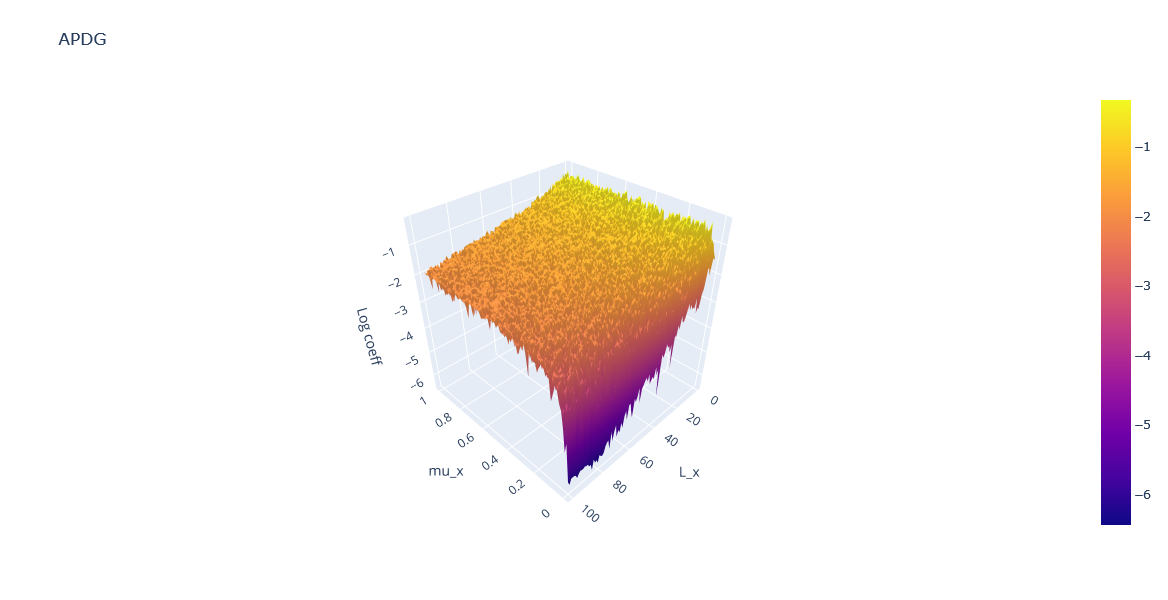

In [95]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# Read data from a csv
z = coefs["APDG"]

fig = go.Figure()
fig.add_trace(go.Surface(z=z, x=MU_RANGE, y=L_RANGE))
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=1.5, z=1.5)
)
fig.update_layout(title='APDG', autosize=False,
                  width=600, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis=dict(title="mu_x"),
                             yaxis=dict(title="L_x"),
                             zaxis=dict(title="Log coeff"),
                             camera=camera
                            ),
                 )
fig.show()

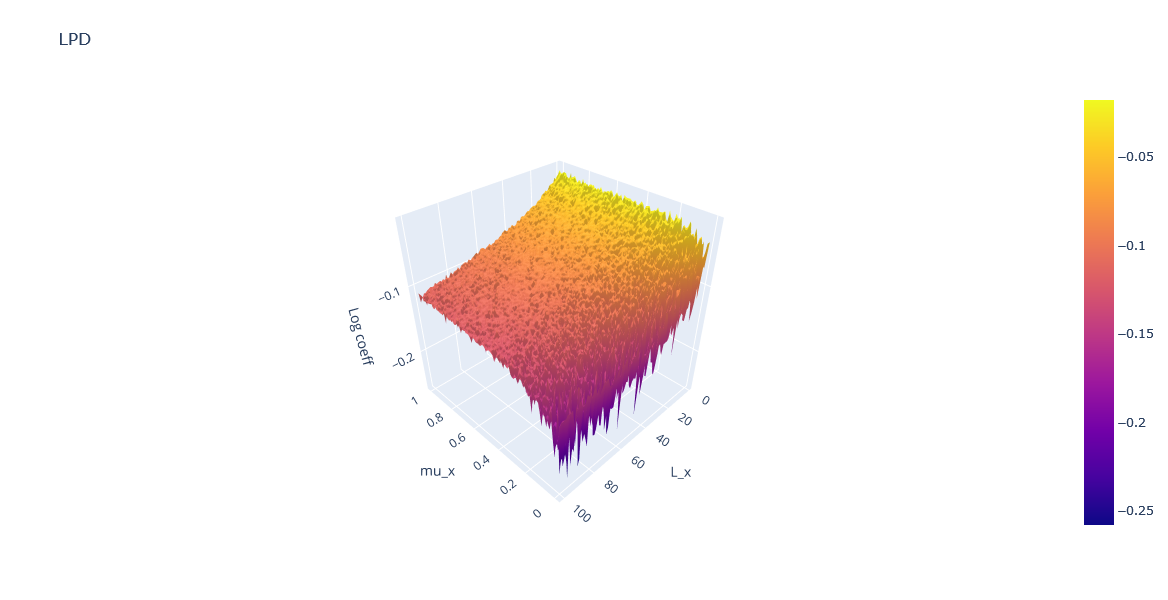

In [92]:
z = coefs["LPD"]
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=1.5, z=1.5)
)
fig = go.Figure()
fig.add_trace(go.Surface(z=z, x=MU_RANGE, y=L_RANGE))
fig.update_layout(title='LPD', autosize=False,
                  width=600, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis=dict(title="mu_x"),
                             yaxis=dict(title="L_x"),
                             zaxis=dict(title="Log coeff"),
                             camera=camera
                            ),
                 )
fig.show()

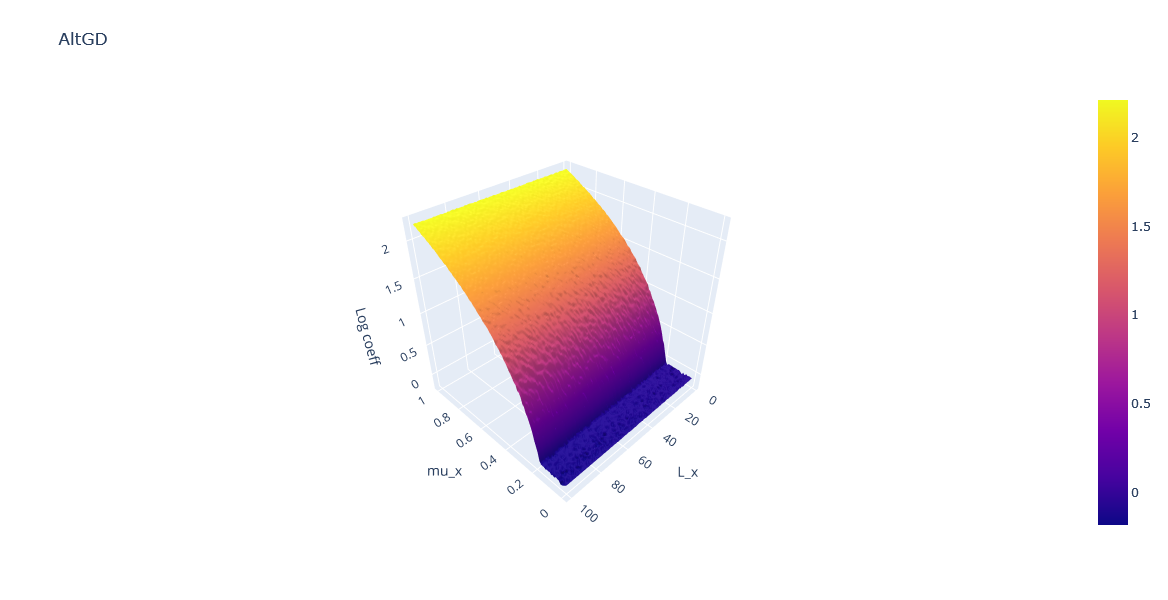

In [93]:
z = coefs["AltGD"]
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=1.5, z=1.5)
)
fig = go.Figure()
fig.add_trace(go.Surface(z=z, x=MU_RANGE, y=L_RANGE))
fig.update_layout(title='AltGD', autosize=False,
                  width=600, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis=dict(title="mu_x"),
                             yaxis=dict(title="L_x"),
                             zaxis=dict(title="Log coeff"),
                             camera=camera
                            ),
                 )
fig.show()

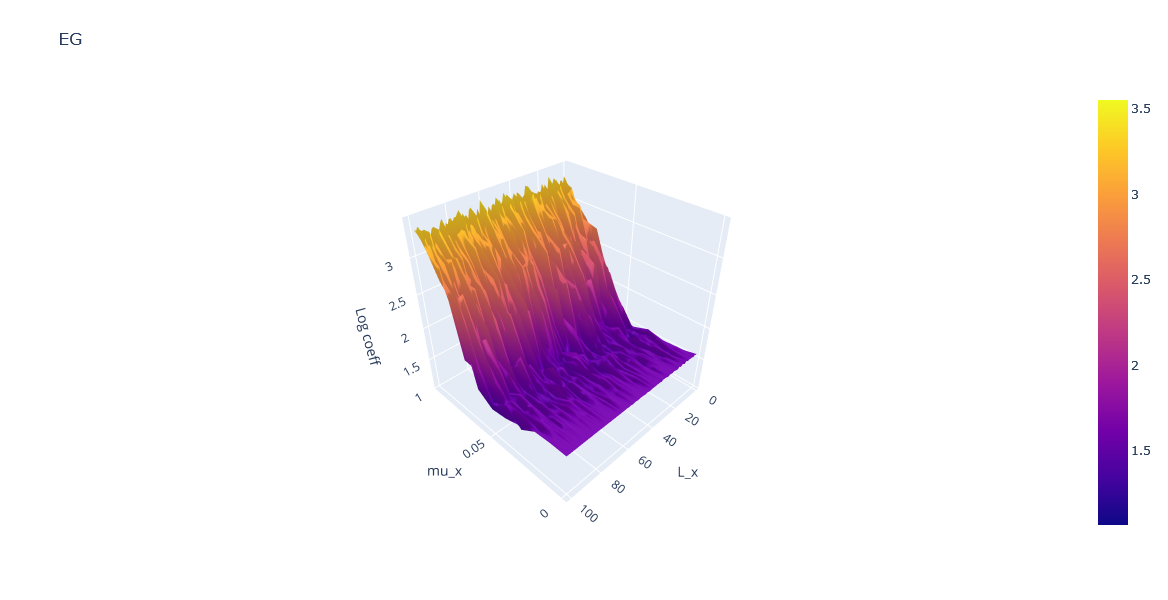

In [96]:
z = coefs["EG"]
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=1.5, z=1.5)
)
fig = go.Figure()
fig.add_trace(go.Surface(z=z, x=MU_RANGE, y=L_RANGE))
fig.update_layout(title='EG', autosize=False,
                  width=600, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis=dict(title="mu_x"),
                             yaxis=dict(title="L_x"),
                             zaxis=dict(title="Log coeff"),
                             camera=camera
                            ),
                 )
fig.show()

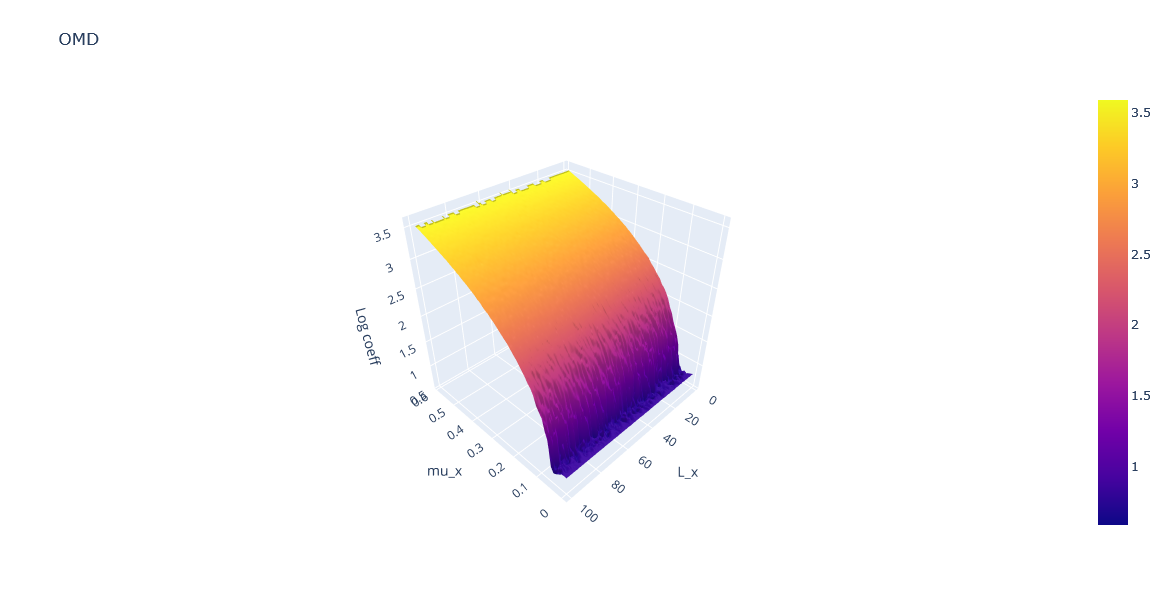

In [97]:
z = coefs["OMD"]
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=1.5, z=1.5)
)
fig = go.Figure()
fig.add_trace(go.Surface(z=z, x=MU_RANGE, y=L_RANGE))
fig.update_layout(title='OMD', autosize=False,
                  width=600, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis=dict(title="mu_x"),
                             yaxis=dict(title="L_x"),
                             zaxis=dict(title="Log coeff"),
                             camera=camera
                            ),
                 )
fig.show()

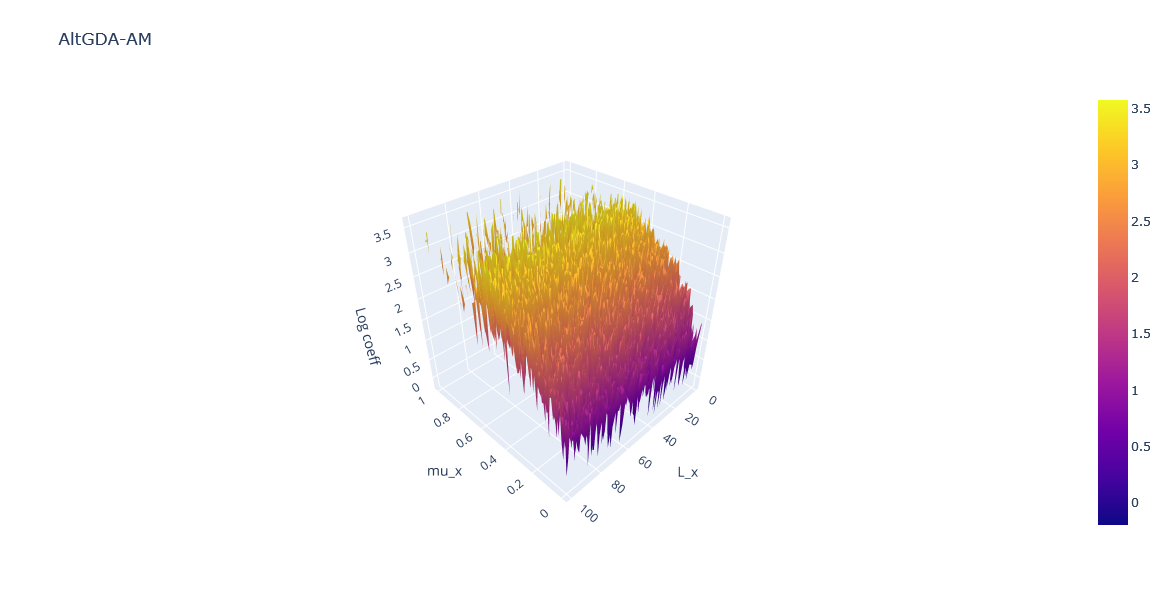

In [98]:
z = coefs["AltGDA-AM"]
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=1.5, z=1.5)
)
fig = go.Figure()
fig.add_trace(go.Surface(z=z, x=MU_RANGE, y=L_RANGE))
fig.update_layout(title='AltGDA-AM', autosize=False,
                  width=600, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis=dict(title="mu_x"),
                             yaxis=dict(title="L_x"),
                             zaxis=dict(title="Log coeff"),
                             camera=camera
                            ),
                 )
fig.show()